# Stress and Achievement, Prediction Plus Prescription

The goal of this notebook is twofold: with a given user’s inputs predict what their level of achievement and daily stress is, and then make recommendations on what they can change to improve their level of stress and achievement. Model building and training were handled with Keras/TensorFlow in a prior notebook so that this notebook could simply load the model and perform inference for a given user in minimal time. The dataset used to train the model is the Lifestile and Wellbeing dataset on Kaggel ( https://www.kaggle.com/ydalat/lifestyle-and-wellbeing-data ).

When this notebook is run it will ask the user for a series of inputs relating to the survey questions from the training dataset. These inputs will be used to create a dataframe, the first row of the dataframe (index 'Actual') will be the user’s inputs, then it will generates additional dataframe rows keeping all the user inputs the same except incrementing/decrementing one element by one (the index label states the change). This dataframe will be fed to the model for predictions. This way a user can observe how a small lifestyle change could impact their life.


Disclaimers: Correlation and causation are not the same, the recommendations this notebook generates may not have the expected impact. While this model is able to accurately approximate the level of daily stress, it is less precise with achievement. Achievement most likely has some confounding variables involved, so take these recommendations with a grain of salt. My recommendation would be to look at the predictions for achievement under 'Actual' and if they accurately reflect your current state then I would imagine the predictions given slight changes would also stay similarly accurate.

GitHub link for the project, including training notebook and model: https://github.com/Neil-Kloper/Stress-and-Achievement-Prediction-Plus-Prescription

Thanks Yvon Dalat ( https://www.kaggle.com/ydalat ) for making the dataset public in the first place and for updating the dataset so I could improve my models performance.

In [1]:

#@title Model, data preprocessing, and definition loading

# Loads the model from the github page
!git clone https://github.com/Neil-Kloper/Stress-and-Achievement-Prediction-Plus-Prescription/

import numpy as np
import pandas as pd

# The ordered list of columns used in inference
x_columns = [
    'FRUITS_VEGGIES',
    'PLACES_VISITED',
    'CORE_CIRCLE',
    'SUPPORTING_OTHERS',
    'SOCIAL_NETWORK',
    'DONATION',
    'TODO_COMPLETED',
    'FLOW',
    'DAILY_STEPS',
    'LIVE_VISION',
    'SLEEP_HOURS',
    'LOST_VACATION',
    'DAILY_SHOUTING',
    'PERSONAL_AWARDS',
    'TIME_FOR_PASSION',
    'WEEKLY_MEDITATION',
    'AGE'
]

# Dictionary containing the column description for assisting the user understanding the column values
wellbeing_dict = {
     'FRUITS_VEGGIES' : '[Between 1 and 5] HOW MANY FRUITS OR VEGETABLES DO YOU EAT EVERYDAY? In a typical day, averaging workdays and weekends.',
     'DAILY_STRESS' : '[Between 1 and 10] HOW MUCH STRESS DO YOU TYPICALLY EXPERIENCE EVERYDAY? At work or at home, due to the environment (noise, pollution, insecurity...), your co-workers or boss, or because of tragic events such as divorce, job loss, serious illness, loss of family or friends,... In average over 12 months.',
     'PLACES_VISITED' : '[Between 0 and 10] HOW MANY NEW PLACES DO YOU VISIT? Over a period of 12 months. Include new states, new cities as well as museum, places of interest and parks in your neighborhood.',
     'CORE_CIRCLE' : '[Between 0 and 10] HOW MANY PEOPLE ARE VERY CLOSE TO YOU? i.e. close family and friends ready to provide you with a long-term unconditional support.',
     'SUPPORTING_OTHERS' : '[Between 0 and 10] HOW MANY PEOPLE DO YOU HELP ACHIEVE A BETTER LIFE? A reflection of your altruism or selflessness  e.g.: caring for your family, actively supporting a friend, mentoring, coaching, developing or promoting a co-worker, ... Over a period of 12 months.',
     'SOCIAL_NETWORK' : '[Between 0 and 10] WITH HOW MANY PEOPLE DO YOU INTERACT WITH DURING A TYPICAL DAY? True interactions and dialogues at home, at work, at the gym, ... Average of workdays and weekends',
     'ACHIEVEMENT' : '[Between 0 and 10] HOW MANY REMARKABLE ACHIEVEMENTS ARE YOU PROUD OF? Over the last 12 months, personal achievements known to your family, close friends or co-workers such as: running a marathon or important race, birth, successful kids, new house or major renovation, major success at work, opening a new business, ...',
     'DONATION' : '[Between 0 and 5] HOW MANY TIMES DO YOU DONATE YOUR TIME OR MONEY TO GOOD CAUSES? Over a period of 12 months. Include financial donation, your time contribution, fundraising, volunteering, serving your country and the poor, ...',
     'BMI_RANGE' : '[1 if below 25, else 2] WHAT IS YOUR BODY MASS INDEX (BMI) RANGE? Your body mass in kg divided by the square of your height in meters ► Check the online BMI calculator such as www.cdc.gov/healthyweight/assessing/bmi/index.html. ► For instance, an adult of 6 feet and 184 pounds has a BMI of 25',
     'TODO_COMPLETED' : '[Between 1 and 10] HOW WELL DO YOU COMPLETE YOUR WEEKLY TO-DO LISTS? Include your weekly goals, work- and personal-related tasks. On a scale of 0 = not at all to 10 = very well.',
     'FLOW' : '[Between 0 and 10] IN A TYPICAL DAY, HOW MANY HOURS DO YOU EXPERIENCE "FLOW"? `Flow` is defined as the mental state, in which you are fully immersed in performing an activity. You then experience a feeling of energized focus, full involvement, and enjoyment in the process of this activity',
     'DAILY_STEPS' : '[Between 0 and 10] HOW MANY STEPS (IN THOUSANDS) DO YOU TYPICALLY WALK EVERYDAY? Thousand steps, daily average over multiple days including work days and week-end.',
     'LIVE_VISION' : '[Between 0 and 10] FOR HOW MANY YEARS AHEAD IS YOUR LIFE VISION VERY CLEAR FOR? For instance, illustrated in a vision board, detailed in a personal journal or openly discussed with your spouse or close friends.',
     'SLEEP_HOURS' : '[Between 0 and 10] ABOUT HOW LONG DO YOU TYPICALLY SLEEP? Over the course of a typical working week, including week-end.',
     'LOST_VACATION' : '[Between 0 and 10] HOW MANY DAYS OF VACATION DO YOU TYPICALLY LOSE EVERY YEAR ? Unused vacation days, lost or carried forward into the following year. Or because of work stress during your vacation.',
     'DAILY_SHOUTING' : '[Between 0 and 10] HOW OFTEN DO YOU SHOUT OR SULK AT SOMEBODY? In a typical week. Expressing your negative emotions in an active or passive manner.',
     'SUFFICIENT_INCOME' : '[1 for insufficient, 2 for sufficient] HOW SUFFICIENT IS YOUR INCOME TO COVER BASIC LIFE EXPENSES? Such as the costs of housing, food, health care, car and education.',
     'PERSONAL_AWARDS' : '[Between 0 and 10] HOW MANY RECOGNITIONS HAVE YOU RECEIVED IN YOUR LIFE? Significant public recognitions validating a personal level of expertise and engagement E.g.: diploma, degree, certificate, accreditation, award, prize, published book, presentation at major conference, medals, cups, titles...',
     'TIME_FOR_PASSION' : '[Between 0 and 10] HOW MANY HOURS DO YOU SPEND EVERYDAY DOING WHAT YOU ARE PASSIONATE ABOUT? Daily hours spent doing what you are passionate and dreaming about, and/or contributing to a greater cause: health, education, peace, society development, ...',
     'WEEKLY_MEDITATION' : '[Between 0 and 10] IN A TYPICAL WEEK, HOW MANY TIMES DO YOU HAVE THE OPPORTUNITY TO THINK ABOUT YOURSELF? Include meditation, praying and relaxation activities such as fitness, walking in a park or lunch breaks.',
     'AGE' : "[1 = 'Less than 20' 2 = '21 to 35' 3 = '36 to 50' 4 = '51 or more'] How old are you?",
     'GENDER' : "[1 = 'Female' 0 = 'Male']"
 }

# Stats relating to each feature from the dataset, the first value is the mean second is the standard deviation. Used for feature scaling
wellbeing_stats = {
    'FRUITS_VEGGIES': (2.9226723436228164, 1.4427392618232717),
    'DAILY_STRESS': (2.7916849289336922, 1.3678007467520172),
    'PLACES_VISITED': (5.233235238870453, 3.3118466202433825),
    'CORE_CIRCLE': (5.508296287020224, 2.8402868211101433),
    'SUPPORTING_OTHERS': (5.616179325026611, 3.2419369588232674),
    'SOCIAL_NETWORK': (6.474046709661261, 3.08664272775673),
    'ACHIEVEMENT': (4.000688748356396, 2.7559123263254053),
    'DONATION': (2.715171247886795, 1.851556132858851),
    'BMI_RANGE': (1.410619247385887, 0.491961619609354),
    'TODO_COMPLETED': (5.745977083463778, 2.6241786624245114),
    'FLOW': (3.194477490451443, 2.3572846752920262),
    'DAILY_STEPS': (5.703587752801954, 2.8911020666495197),
    'LIVE_VISION': (3.7521758186713416, 3.2310825267930916),
    'SLEEP_HOURS': (7.042952852044331, 1.199053434423808),
    'LOST_VACATION': (2.8984409241750675, 3.6918674791997406),
    'DAILY_SHOUTING': (2.930999937386513, 2.6763413227911825),
    'SUFFICIENT_INCOME': (1.7289462150147141, 0.4445177193376449),
    'PERSONAL_AWARDS': (5.711289211696199, 3.0895399360748805),
    'TIME_FOR_PASSION': (3.3262788804708534, 2.729127663833442),
    'WEEKLY_MEDITATION': (6.233610919792123, 3.0164794474060197),
    'AGE': (2.602091290463966, 0.9444260282900208),
    'GENDER': (0.6172437543046773, 0.48607478404407434),
    'WORK_LIFE_BALANCE_SCORE': (666.75051029992, 45.0211030065477)
}


import tensorflow as tf
import tensorflow_hub as hub

# Load the model
model = hub.load('/content/Stress-and-Achievement-Prediction-Plus-Prescription/model/wellbeing_model')

# Print model summary (check activation function)
for layer in model.signatures["serving_default"].structured_outputs:
    print(layer, " -> ", model.signatures["serving_default"].structured_outputs[layer])


Cloning into 'Stress-and-Achievement-Prediction-Plus-Prescription'...


ModuleNotFoundError: No module named 'tensorflow'

When you run this cell enter the numbers for each survey question as prompted.

In [2]:
import numpy as np
import pandas as pd

list_pred = []

for col in x_columns:
    print(wellbeing_dict[col])
    try:
        list_pred.append(int(input()))
    except:
        print('Invalid input entered, placeholder value entered (3)')
        list_pred.append(3)

# Create a batch of predictions with slight variations
pred_dict = {'Actual': list_pred}
idx = 0

for num in list_pred:
    if num < 10:
        plus_1 = list_pred.copy()
        plus_1[idx] = num + 1
        pred_dict[f"{x_columns[idx]} plus 1"] = plus_1
    if num > 0:
        minus_1 = list_pred.copy()
        minus_1[idx] = num - 1
        pred_dict[f"{x_columns[idx]} minus 1"] = minus_1
    idx += 1

# Convert prediction dictionary into a DataFrame
personal_preds_batch = pd.DataFrame.from_dict(pred_dict, orient='index', columns=x_columns)

# Normalize inputs using dataset statistics
# for col in x_columns:
#     personal_preds_batch[col] = (personal_preds_batch[col] - wellbeing_stats[col][0]) / wellbeing_stats[col][1]

# Alternative normalization approach (try this change)
for col in x_columns:
    personal_preds_batch[col] = (personal_preds_batch[col] - wellbeing_stats[col][0]) / (wellbeing_stats[col][1] + 1e-7)  # Prevents division errors


print("✅ User input collected and preprocessed!")


[Between 1 and 5] HOW MANY FRUITS OR VEGETABLES DO YOU EAT EVERYDAY? In a typical day, averaging workdays and weekends.
3
[Between 0 and 10] HOW MANY NEW PLACES DO YOU VISIT? Over a period of 12 months. Include new states, new cities as well as museum, places of interest and parks in your neighborhood.
4
[Between 0 and 10] HOW MANY PEOPLE ARE VERY CLOSE TO YOU? i.e. close family and friends ready to provide you with a long-term unconditional support.
6
[Between 0 and 10] HOW MANY PEOPLE DO YOU HELP ACHIEVE A BETTER LIFE? A reflection of your altruism or selflessness  e.g.: caring for your family, actively supporting a friend, mentoring, coaching, developing or promoting a co-worker, ... Over a period of 12 months.
5
[Between 0 and 10] WITH HOW MANY PEOPLE DO YOU INTERACT WITH DURING A TYPICAL DAY? True interactions and dialogues at home, at work, at the gym, ... Average of workdays and weekends
3
[Between 0 and 5] HOW MANY TIMES DO YOU DONATE YOUR TIME OR MONEY TO GOOD CAUSES? Over a p

Below are the predictions based on the input. The first row is the results based on the actual input, after that, it has estimates for if a user made a change. The row names describe the change to have the alternate outcome. A color gradient has been applied to help more significant changes stick out better.

Daily stress as defined in the survey questions: HOW MUCH STRESS DO YOU TYPICALLY EXPERIENCE EVERYDAY? At work or at home, due to the environment (noise, pollution, insecurity...), your co-workers or boss, or because of tragic events such as divorce, job loss, serious illness, loss of family or friends,... In average over 12 months.

Achievement as defined in the survey questions: HOW MANY REMARKABLE ACHIEVEMENTS ARE YOU PROUD OF? Over the last 12 months, personal achievements known to your family, close friends or co-workers such as: running a marathon or important race, birth, successful kids, new house or major renovation, major success at work, opening a new business, ...

In [3]:
import tensorflow as tf
import numpy as np

# Create a batch of predictions with slight variations
pred_dict = {}
pred_dict['Actual'] = list_pred  # Original input values
idx = 0

for num in list_pred:
    if num < 10:
        plus_1 = list_pred.copy()
        plus_1[idx] = num + 1
        label = str(x_columns[idx]) + ' plus 1'
        pred_dict[label] = plus_1
    if num > 0:
        minus_1 = list_pred.copy()
        minus_1[idx] = num - 1
        label = str(x_columns[idx]) + ' minus 1'
        pred_dict[label] = minus_1
    idx += 1

# Convert prediction dictionary into a DataFrame
personal_preds_batch = pd.DataFrame.from_dict(pred_dict, orient='index', columns=x_columns)

# Normalize inputs using dataset statistics
for col in x_columns:
    personal_preds_batch[col] = (personal_preds_batch[col] - wellbeing_stats[col][0]) / wellbeing_stats[col][1]

# Convert DataFrame to numpy array with float64 dtype
X_input_np = personal_preds_batch.to_numpy(dtype=np.float64)

# Convert numpy array to TensorFlow tensor with explicit dtype
X_input = tf.convert_to_tensor(X_input_np, dtype=tf.float64) # Ensure float64

# Make predictions using the model
predictions = model(X_input)

# Convert tensor output to numpy array
predictions_np = predictions.numpy()

# Extract Predictions for DAILY_STRESS & ACHIEVEMENT
personal_preds_batch[['DAILY_STRESS', 'ACHIEVEMENT']] = predictions_np

# Ensure predictions are within valid range (1-5 for stress)
personal_preds_batch['DAILY_STRESS'] = np.clip(np.round(personal_preds_batch['DAILY_STRESS']), 1, 5)

# Display Results with Gradient Background
personal_preds_batch[['DAILY_STRESS', 'ACHIEVEMENT']].style.background_gradient()


,DAILY_STRESS,ACHIEVEMENT
Actual,3.000000,5.850747
FRUITS_VEGGIES plus 1,3.000000,5.709961
FRUITS_VEGGIES minus 1,3.000000,6.014306
PLACES_VISITED plus 1,3.000000,5.950301
PLACES_VISITED minus 1,3.000000,5.743411
CORE_CIRCLE plus 1,3.000000,5.905629
CORE_CIRCLE minus 1,3.000000,5.823801
SUPPORTING_OTHERS plus 1,3.000000,5.967022
SUPPORTING_OTHERS minus 1,3.000000,5.713798
SOCIAL_NETWORK plus 1,3.000000,5.845300


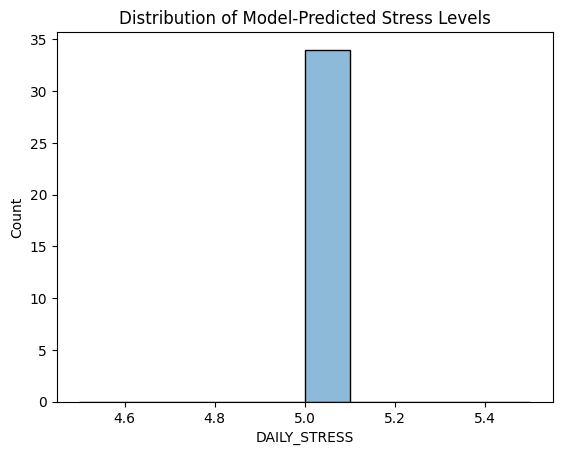

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing the spread of stress predictions
sns.histplot(personal_preds_batch["DAILY_STRESS"], bins=10, kde=True)
plt.title("Distribution of Model-Predicted Stress Levels")
plt.show()


### Thanks for your time!

If you have any feedback, questions, or concerns about this notebook you can leave a comment on the Kaggle page for this notebook  ( https://www.kaggle.com/schorsi/stress-and-achievement-prediction-prescription ) or reach out to me on linkedin ( https://www.linkedin.com/in/neil-kloper/ )